In [7]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
import pickle
from jupyter_dash import JupyterDash
import dash
from dash import dcc 
from dash import html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw,ImageFont
import seaborn as sns
#sns.set()
import arviz as az
import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import os
import re
import glob
import random
# import plotnine
from sklearn import preprocessing
from tqdm import tqdm

# import plotnine 
# from plotnine.data import economics 
# from plotnine import * 
import plotly.express as px

from skimage import measure, restoration,morphology
from skimage import io, filters, measure, color, img_as_ubyte
from skimage.draw import disk
from skimage import measure, restoration,morphology

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)


%config InlineBackend.figure_format = 'retina'
os.chdir(r'F:\HAB_2\PrinzScreen\training_classfication')
from utils import AIPS_cellpose as AC
from utils import AIPS_file_display as AFD

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


3.11.5


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


# Logistic regression 
Decay formula:\
<Br>
$ Signal(t) = a \times Signal(t0) \times e^{-b \times kernel}$\
<Br>
$b =  - \frac {ln \frac {Signal(t)}{Signal(t0)}}{Kernel}$
<Br>
Remove the minus sign for compatebility with logistic\
Add a parmetre and beta
$ \theta = logistic(a + \beta \frac {ln \frac {Signal(t)}{Signal(t0)}}{Kernel})$
---

- [ ] Divide signal by median per image, add class culomn and remove all the zeros
- [ ] Add Signal start (Signal(t0)) and Signal(t)
- [ ] Plot b per image 
- [ ] Remove ambiguous signal
- [ ] Concatenate data_frames

In [22]:
def add_class_select(ones_,zero_,table):
    table['class'] = 0
    table.loc[table['image_group'].values == ones_,'class'] = 1
    df = pd.concat((table.loc[table['image_group'].values == ones_,:],
                   table.loc[table['image_group'].values == zero_,:]),0)
    return df

def add_rate_column(df):
    un = np.unique(df['image_group'])
    # adding Signal start and finsh
    df['Nt'] = 0
    df['Kernel'] = df.raius_list.values+1
    for un_ in un:
        df_temp = df.loc[df['image_group'].values==un_,:]
        df.loc[df['image_group']==un_,'Nt'] = np.repeat(df_temp.iloc[0,4],len(df_temp))
    df['b'] = -1*(np.log(df.image_signal_norm.values/df.Nt.values)/df.Kernel.values)
    # Keep until 20
    for un_ in un:
        df_temp = df.loc[df['image_group'].values==un_,:]
        df.loc[df['image_group']==un_,'b'] = np.mean(df_temp.b.values[1:20])
#    plt.figure(figsize=(5, 20))
#     sns.catplot(x="image_group", y="b",
#             hue="class", palette=["m", "g"],
#             data=df,
#            height=5, # make the plot 5 units high
#             aspect=4)
    return df


def Class_table(path_Table_img,file_name,path_class,file_class):
    table = pd.read_csv(os.path.join(path_Table_img,file_name))
    table['image_signal_norm'] = table.image_signal.values/np.median(table.loc[table['raius_list']==0,'image_signal'])
    # upload class
    with open(os.path.join(path_class,file_class)) as f:
        class_r = f.readline()
    Pheno_list = [int(x) for x in class_r.split(';')] 
    zero_list = [zz for zz in np.arange(np.max(Pheno_list)).tolist() if zz not in Pheno_list]
    ### Adding classes
    df = pd.DataFrame(columns = table.columns)
    for i in range(len(Pheno_list)):
        df_temp = add_class_select(Pheno_list[i],zero_list[i],table)
        df = pd.concat((df,df_temp),0)
    df_rate = add_rate_column(df)
    df_rate['Image_name_unique'] = file_name
    return df_rate

In [23]:
path = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6'
path_class = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6\class_update' # update from Remove_obser...

Table_mix_0 = Class_table(path,'table_img0.csv',path_class,'class_0.txt')
Table_mix_1 = Class_table(path,'table_img1.csv',path_class,'class_1.txt')
Table_mix_2 = Class_table(path,'table_img2.csv',path_class,'class_2.txt')
Table_mix_3 = Class_table(path,'table_img3.csv',path_class,'class_3.txt')
Table_mix_4 = Class_table(path,'table_img4.csv',path_class,'class_4.txt')
Table_mix_5 = Class_table(path,'table_img5.csv',path_class,'class_5.txt')
Table_mix_6 = Class_table(path,'table_img6.csv',path_class,'class_6.txt')
Table_sum = pd.concat((Table_mix_0,Table_mix_1,Table_mix_2,Table_mix_3,Table_mix_4,Table_mix_5,Table_mix_6),0)
Table_sum.head(2)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


,Unnamed: 0,image_signal,raius_list,image_group,image_signal_norm,class,Nt,Kernel,b,Image_name_unique
17680,17680,3279.715582,0,221,1.892512,1.0,1.892512,1,0.019165,table_img0.csv
17681,17681,3243.717554,1,221,1.871740,1.0,1.892512,2,0.019165,table_img0.csv


# Decay rate (b) as input for Logistic regression

In [47]:
un_Image = np.unique(Table_sum['Image_name_unique'])
rate = []
image_group = []
Image_name_unique = []
class_list = []
for image in un_Image:
    table_temp = Table_sum.loc[Table_sum["Image_name_unique"]==image,:]
    un_num = np.unique(table_temp['image_group'])
    for num in un_num:
        rate.append(np.unique(table_temp.loc[table_temp["image_group"]==num,'b'])[0])
        image_group.append(num)
        class_list.append(np.unique(table_temp.loc[table_temp["image_group"]==num,'class'])[0])    
df_collect = pd.DataFrame({'image_group':image_group,'rate':rate,'class_list':class_list})
df_collect = df_collect.sample(len(df_collect)) #suffle
df_train = df_collect.iloc[:120,:]
df_train['unique'] = np.arange(len(df_train))
df_test = df_collect.iloc[121:len(df_collect),:]
df_test['unique'] = np.arange(len(df_test))

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
rate = df_train.rate.values
y_0 = df_train.class_list.values
with pm.Model() as model_logistic_basic:
    a = pm.Normal('a',0,10)
    b = pm.Normal('b',0,10)
    mu = a + pm.math.dot(rate,b)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd',-a/b)
    yl = pm.Bernoulli('yl',theta,observed = y_0)
    trace = pm.sample(4000, tune=4000, target_accept=0.99,random_seed=RANDOM_SEED)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 61 seconds.


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

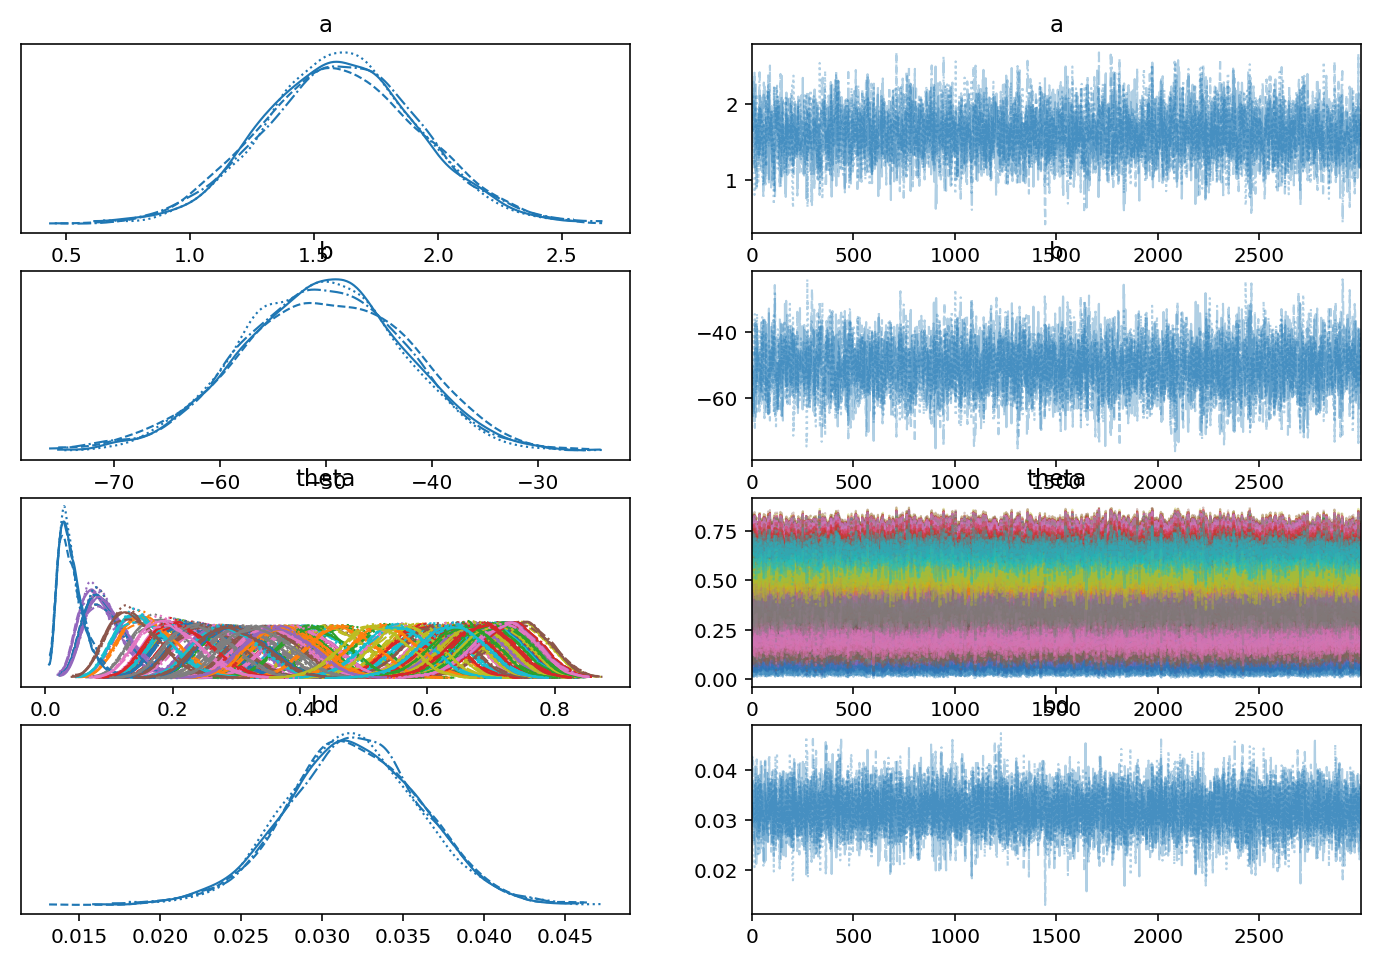

In [53]:
chain_1 = trace[1000:]
pm.traceplot(chain_1)

In [54]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.609,0.315,1.026,2.212,0.005,0.003,4783.0,5411.0,1.0
b,-50.345,7.600,-65.050,-36.577,0.110,0.078,4776.0,5111.0,1.0
theta[0],0.228,0.048,0.144,0.322,0.000,0.000,9742.0,8482.0,1.0
theta[1],0.626,0.050,0.532,0.720,0.001,0.000,6673.0,8038.0,1.0
theta[2],0.226,0.048,0.140,0.317,0.000,0.000,9686.0,8482.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[116],0.195,0.046,0.115,0.286,0.000,0.000,8908.0,8185.0,1.0
theta[117],0.335,0.050,0.244,0.432,0.000,0.000,11606.0,8795.0,1.0
theta[118],0.518,0.050,0.421,0.609,0.001,0.000,9830.0,8777.0,1.0
theta[119],0.637,0.050,0.542,0.730,0.001,0.000,6476.0,7909.0,1.0


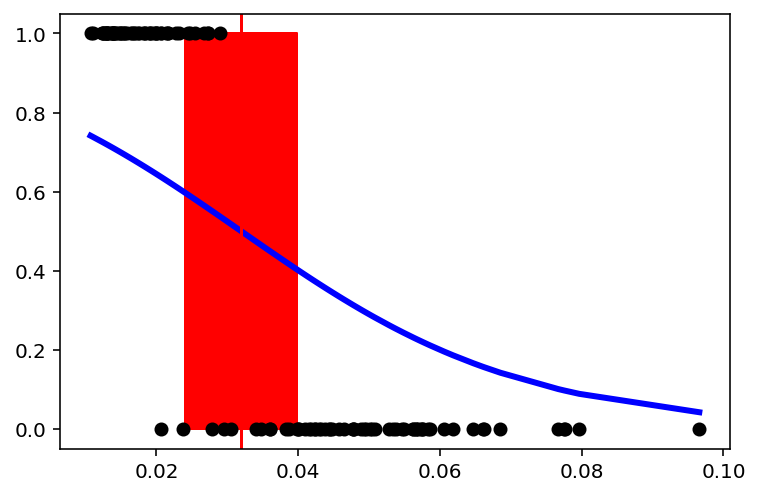

In [57]:
theta = trace['theta'].mean(0)
idx = np.argsort(rate)
plt.plot(rate[idx],theta[idx],color ='b',lw=3)
plt.axvline(trace['bd'].mean(),ymax=1,color = 'r')
bd_hdi = pm.hdi(trace['bd'])
plt.fill_betweenx([0,1],bd_hdi[0],bd_hdi[1], color = 'r')
plt.plot(rate,y_0,'o',color = 'k')


In [96]:
def classify(n,thold):
    mu = trace['a'].mean() + trace['b'].mean() * n
    prob = 1 /(1  + np.exp(-mu))
    return prob, prob > thold
rate = df_train.rate.values
td = 0.5
prob,prediction = classify(rate,td)

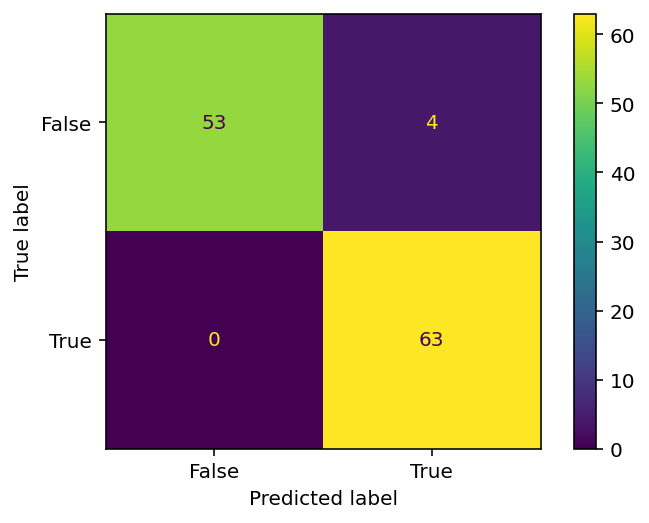

In [97]:
from sklearn import metrics 
confusion_matrix = metrics.confusion_matrix(np.array(df_train.class_list.values,dtype = int), np.where(prediction,1,0)) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

# Test samples prediction

In [81]:
def classify(n,thold):
    mu = trace['a'].mean() + trace['b'].mean() * n
    prob = 1 /(1  + np.exp(-mu))
    return prob, prob > thold
rate = df_test.rate.values
td = 0.5
prob,prediction = classify(rate,td)

In [82]:
np.where(prediction,1,0)

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0])

In [86]:
np.array(df_test.class_list.values,dtype = int)

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


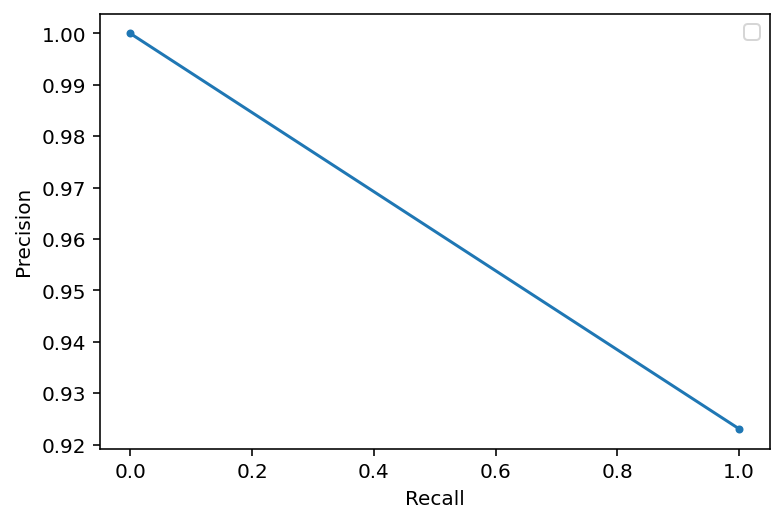

In [92]:
from sklearn import metrics 
confusion_matrix = metrics.confusion_matrix(np.array(df_test.class_list.values,dtype = int), np.where(prediction,1,0)) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

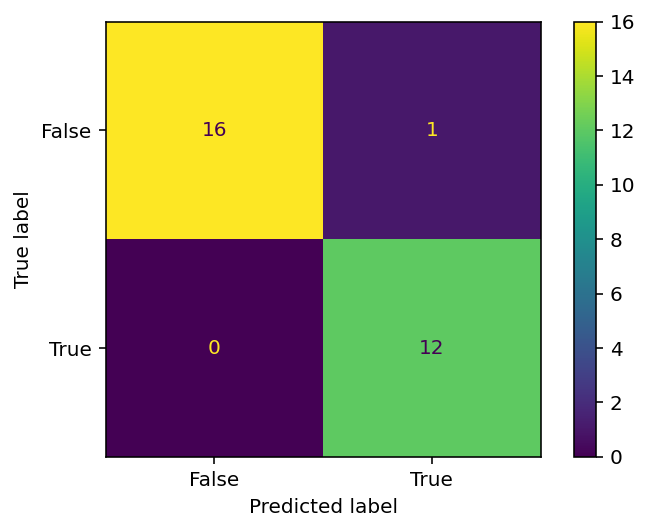

In [ ]:
# Test Kernel 20 for prediction

In [98]:
def add_class_select(ones_,zero_,table):
    table['class'] = 0
    table.loc[table['image_group'].values == ones_,'class'] = 1
    df = pd.concat((table.loc[table['image_group'].values == ones_,:],
                   table.loc[table['image_group'].values == zero_,:]),0)
    return df

def add_rate_column(df):
    un = np.unique(df['image_group'])
    # adding Signal start and finsh
    df['Nt'] = 0
    df['Kernel'] = df.raius_list.values+1
    for un_ in un:
        df_temp = df.loc[df['image_group'].values==un_,:]
        df.loc[df['image_group']==un_,'Nt'] = np.repeat(df_temp.iloc[0,4],len(df_temp))
    df['b'] = -1*(np.log(df.image_signal_norm.values/df.Nt.values)/df.Kernel.values)
    df['b20'] = 0
    # Keep until 20
    for un_ in un:
        df_temp = df.loc[df['image_group'].values==un_,:]
        df.loc[df['image_group']==un_,'b'] = np.mean(df_temp.b.values[1:20])
        df.loc[df['image_group']==un_,'b20'] = df_temp.b.values[20]
        
#    plt.figure(figsize=(5, 20))
#     sns.catplot(x="image_group", y="b",
#             hue="class", palette=["m", "g"],
#             data=df,
#            height=5, # make the plot 5 units high
#             aspect=4)
    return df


def Class_table(path_Table_img,file_name,path_class,file_class):
    table = pd.read_csv(os.path.join(path_Table_img,file_name))
    table['image_signal_norm'] = table.image_signal.values/np.median(table.loc[table['raius_list']==0,'image_signal'])
    # upload class
    with open(os.path.join(path_class,file_class)) as f:
        class_r = f.readline()
    Pheno_list = [int(x) for x in class_r.split(';')] 
    zero_list = [zz for zz in np.arange(np.max(Pheno_list)).tolist() if zz not in Pheno_list]
    ### Adding classes
    df = pd.DataFrame(columns = table.columns)
    for i in range(len(Pheno_list)):
        df_temp = add_class_select(Pheno_list[i],zero_list[i],table)
        df = pd.concat((df,df_temp),0)
    df_rate = add_rate_column(df)
    df_rate['Image_name_unique'] = file_name
    return df_rate

In [99]:
path = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6'
path_class = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6\class_update' # update from Remove_obser...

Table_mix_0 = Class_table(path,'table_img0.csv',path_class,'class_0.txt')
Table_mix_1 = Class_table(path,'table_img1.csv',path_class,'class_1.txt')
Table_mix_2 = Class_table(path,'table_img2.csv',path_class,'class_2.txt')
Table_mix_3 = Class_table(path,'table_img3.csv',path_class,'class_3.txt')
Table_mix_4 = Class_table(path,'table_img4.csv',path_class,'class_4.txt')
Table_mix_5 = Class_table(path,'table_img5.csv',path_class,'class_5.txt')
Table_mix_6 = Class_table(path,'table_img6.csv',path_class,'class_6.txt')
Table_sum = pd.concat((Table_mix_0,Table_mix_1,Table_mix_2,Table_mix_3,Table_mix_4,Table_mix_5,Table_mix_6),0)
Table_sum.head(2)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


,Unnamed: 0,image_signal,raius_list,image_group,image_signal_norm,class,Nt,Kernel,b,b20,Image_name_unique
17680,17680,3279.715582,0,221,1.892512,1.0,1.892512,1,0.019165,0.026171,table_img0.csv
17681,17681,3243.717554,1,221,1.871740,1.0,1.892512,2,0.019165,0.026171,table_img0.csv


In [100]:
un_Image = np.unique(Table_sum['Image_name_unique'])
rate = []
rate_b20 = []
image_group = []
Image_name_unique = []
class_list = []
for image in un_Image:
    table_temp = Table_sum.loc[Table_sum["Image_name_unique"]==image,:]
    un_num = np.unique(table_temp['image_group'])
    for num in un_num:
        rate.append(np.unique(table_temp.loc[table_temp["image_group"]==num,'b'])[0])
        rate_b20.append(np.unique(table_temp.loc[table_temp["image_group"]==num,'b20'])[0])
        image_group.append(num)
        class_list.append(np.unique(table_temp.loc[table_temp["image_group"]==num,'class'])[0])    
df_collect = pd.DataFrame({'image_group':image_group,'rate':rate,'rate_b20':rate_b20,'class_list':class_list})
df_collect = df_collect.sample(len(df_collect)) #suffle
df_train = df_collect.iloc[:120,:]
df_train['unique'] = np.arange(len(df_train))
df_test = df_collect.iloc[121:len(df_collect),:]
df_test['unique'] = np.arange(len(df_test))

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
rate = df_train.rate_b20.values
y_0 = df_train.class_list.values
with pm.Model() as model_logistic_basic:
    a = pm.Normal('a',0,10)
    b = pm.Normal('b',0,10)
    mu = a + pm.math.dot(rate,b)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd',-a/b)
    yl = pm.Bernoulli('yl',theta,observed = y_0)
    trace = pm.sample(4000, tune=4000, target_accept=0.99,random_seed=RANDOM_SEED)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 58 seconds.
The number of effective samples is smaller than 25% for some parameters.


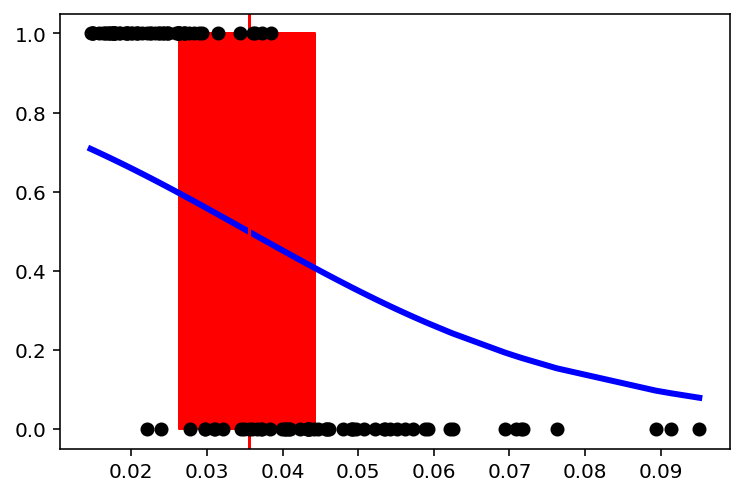

In [104]:
theta = trace['theta'].mean(0)
idx = np.argsort(rate)
plt.plot(rate[idx],theta[idx],color ='b',lw=3)
plt.axvline(trace['bd'].mean(),ymax=1,color = 'r')
bd_hdi = pm.hdi(trace['bd'])
plt.fill_betweenx([0,1],bd_hdi[0],bd_hdi[1], color = 'r')
plt.plot(rate,y_0,'o',color = 'k')

In [105]:
def classify(n,thold):
    mu = trace['a'].mean() + trace['b'].mean() * n
    prob = 1 /(1  + np.exp(-mu))
    return prob, prob > thold
rate = df_train.rate.values
td = 0.5
prob,prediction = classify(rate,td)

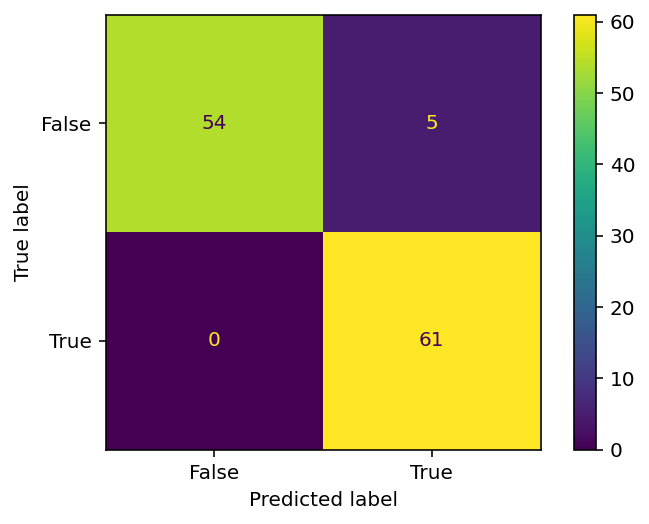

In [106]:
from sklearn import metrics 
confusion_matrix = metrics.confusion_matrix(np.array(df_train.class_list.values,dtype = int), np.where(prediction,1,0)) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

# Compute b from 1,5,10,20
Adding parameter for the sequence calculation

In [108]:
def add_class_select(ones_,zero_,table):
    table['class'] = 0
    table.loc[table['image_group'].values == ones_,'class'] = 1
    df = pd.concat((table.loc[table['image_group'].values == ones_,:],
                   table.loc[table['image_group'].values == zero_,:]),0)
    return df

def add_rate_column(df):
    un = np.unique(df['image_group'])
    # adding Signal start and finsh
    df['Nt'] = 0
    df['Kernel'] = df.raius_list.values+1
    for un_ in un:
        df_temp = df.loc[df['image_group'].values==un_,:]
        df.loc[df['image_group']==un_,'Nt'] = np.repeat(df_temp.iloc[0,4],len(df_temp))
#    plt.figure(figsize=(5, 20))
#     sns.catplot(x="image_group", y="b",
#             hue="class", palette=["m", "g"],
#             data=df,
#            height=5, # make the plot 5 units high
#             aspect=4)
    return df


def Class_table(path_Table_img,file_name,path_class,file_class):
    table = pd.read_csv(os.path.join(path_Table_img,file_name))
    table['image_signal_norm'] = table.image_signal.values/np.median(table.loc[table['raius_list']==0,'image_signal'])
    # upload class
    with open(os.path.join(path_class,file_class)) as f:
        class_r = f.readline()
    Pheno_list = [int(x) for x in class_r.split(';')] 
    zero_list = [zz for zz in np.arange(np.max(Pheno_list)).tolist() if zz not in Pheno_list]
    ### Adding classes
    df = pd.DataFrame(columns = table.columns)
    for i in range(len(Pheno_list)):
        df_temp = add_class_select(Pheno_list[i],zero_list[i],table)
        df = pd.concat((df,df_temp),0)
    df_rate = add_rate_column(df)
    df_rate['Image_name_unique'] = file_name
    return df_rate

In [110]:
path = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6'
path_class = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kernel_80_mix_0to6\class_update' # update from Remove_obser...

Table_mix_0 = Class_table(path,'table_img0.csv',path_class,'class_0.txt')
Table_mix_1 = Class_table(path,'table_img1.csv',path_class,'class_1.txt')
Table_mix_2 = Class_table(path,'table_img2.csv',path_class,'class_2.txt')
Table_mix_3 = Class_table(path,'table_img3.csv',path_class,'class_3.txt')
Table_mix_4 = Class_table(path,'table_img4.csv',path_class,'class_4.txt')
Table_mix_5 = Class_table(path,'table_img5.csv',path_class,'class_5.txt')
Table_mix_6 = Class_table(path,'table_img6.csv',path_class,'class_6.txt')
Table_sum = pd.concat((Table_mix_0,Table_mix_1,Table_mix_2,Table_mix_3,Table_mix_4,Table_mix_5,Table_mix_6),0)
Table_sum

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


,Unnamed: 0,image_signal,raius_list,image_group,image_signal_norm,class,Nt,Kernel,Image_name_unique
17680,17680,3279.715582,0,221,1.892512,1.0,1.892512,1,table_img0.csv
17681,17681,3243.717554,1,221,1.871740,1.0,1.892512,2,table_img0.csv
17682,17682,3207.038659,2,221,1.850575,1.0,1.892512,3,table_img0.csv
17683,17683,3160.837870,3,221,1.823915,1.0,1.892512,4,table_img0.csv
17684,17684,3106.424852,4,221,1.792517,1.0,1.892512,5,table_img0.csv
...,...,...,...,...,...,...,...,...,...
795,795,130.016662,75,9,0.052068,0.0,0.759612,76,table_img6.csv
796,796,130.003029,76,9,0.052062,0.0,0.759612,77,table_img6.csv
797,797,130.000000,77,9,0.052061,0.0,0.759612,78,table_img6.csv
798,798,129.948803,78,9,0.052040,0.0,0.759612,79,table_img6.csv


In [ ]:
Table_sum.iloc[17680]

In [111]:
un_Image = np.unique(Table_sum['Image_name_unique'])
rate = []
rate_b20 = []
image_group = []
Image_name_unique = []
class_list = []
df = pd.DataFrame(columns=Table_sum.columns)
kernel_ind = np.array([10,15,20])
for image in un_Image:
    table_temp = Table_sum.loc[Table_sum["Image_name_unique"]==image,:]
    un_num = np.unique(table_temp['image_group'])
    for num in un_num:
        df_temp = table_temp.loc[lambda x (x.[]),:]
        df = pd.concat((df,df_temp),1)
        
# df_collect = pd.DataFrame({'image_group':image_group,'rate':rate,'rate_b20':rate_b20,'class_list':class_list})
# df_collect = df_collect.sample(len(df_collect)) #suffle
# df_train = df_collect.iloc[:120,:]
# df_train['unique'] = np.arange(len(df_train))
# df_test = df_collect.iloc[121:len(df_collect),:]
# df_test['unique'] = np.arange(len(df_test))

ValueError: ('Lengths must match to compare', (800,), (3,))

In [40]:
path_input_table = r'F:\HAB_2\PrinzScreen\output_lab_meeting\kerenl_60_mix'
path_input_class = r'F:\HAB_2\PrinzScreen\output_lab_meeting\kerenl_60_mix\class'
os.chdir(path_input_table)
csv_names = glob.glob("*.csv")
os.chdir(path_input_class)
class_names = glob.glob("*.txt")

In [202]:
table_mix = pd.read_csv(os.path.join(path_input_table,csv_names[0]))
table_mix.columns

Index(['Unnamed: 0', 'label', 'area', 'centroid-0', 'centroid-1',
       'sd_intensity', 'skew_intensity', 'pixelcount', 'mean_int', '0', '60'],
      dtype='object')

In [60]:
def precent_staderisation(in_list):
    max_ = np.max(in_list)
    return in_list/max_

def add_class(path_table,path_class,table_id,class_id):
    if table_id.split('_')[2] != class_id.split('_')[1]:
        print('the files are missmached')
        quit()
    table_mix = pd.read_csv(os.path.join(path_table,table_id))
    # standerize all to the max
    table_mix['area'] = precent_staderisation( table_mix['area'].values)
    table_mix['skew_intensity'] = precent_staderisation( table_mix['skew_intensity'].values)
    table_mix['pixelcount'] = precent_staderisation( table_mix['pixelcount'].values)
    # calculate precentage 
    precent_redaction = table_mix['60']/table_mix['0']
    table_mix['0'] = precent_staderisation(table_mix['0'].values)
    table_mix['60'] =  table_mix['0'].values * precent_redaction
    # adding class
    table_mix['image_group'] = table_id
    table_mix['class'] = 0
    with open(os.path.join(path_class,class_id)) as f:
        class_str = f.readline()
    ind = [int(tx) for tx in class_str.split(';')]
    table_mix.iloc[ind,len(table_mix.columns)-1] = 1
    return table_mix
# for i in range(0):
table_mix_1 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[1],class_id = class_names[1])
table_mix_2 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[2],class_id = class_names[2])
table_mix_3 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[3],class_id = class_names[3])
table_mix_4 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[4],class_id = class_names[4])
table_mix_5 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[5],class_id = class_names[5])
table_mix_6 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[6],class_id = class_names[6])
table_mix_7 = add_class(path_table = path_input_table,path_class = path_input_class,table_id = csv_names[0],class_id = class_names[0])

In [77]:
# Merge tables
table_mix_sum = pd.concat((table_mix_7,table_mix_1,table_mix_2,table_mix_3,table_mix_4,table_mix_5,table_mix_6),0).reset_index()
table_mix_sum = table_mix_sum.rename(columns = {'index':'unique_id'})
table_mix_sum['unique_id'] = table_mix_sum.index.values
from sklearn.utils import shuffle
table_mix_sum = shuffle(table_mix_sum)
table_mix_sum

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,unique_id,Unnamed: 0,label,area,centroid-0,centroid-1,sd_intensity,skew_intensity,pixelcount,mean_int,0,60,image_group,class
6179,6179,1011,1011,0.205692,1673.808931,101.584919,99.576568,-0.051318,0.205692,732.540630,0.295291,0.048112,Table_mix_4_exp001_13DKO_1-4.tif.csv,0
3745,3745,208,208,0.395613,406.125249,641.022337,22.540952,0.044102,0.395613,232.555644,0.106405,0.015234,Table_mix_3_exp001_13DKO_1-3.tif.csv,0
9512,9512,996,996,0.177417,1389.828785,1817.807018,2.992093,-0.001670,0.177417,144.782326,0.234911,0.006519,Table_mix_6_exp001_13DKO_2-2.tif.csv,0
2025,2025,430,430,0.172467,632.374519,2022.365541,0.000000,0.000000,0.172467,420.000000,0.053816,0.013921,Table_mix_2_exp001_13DKO_1-2.tif.csv,0
2113,2113,518,518,0.241778,779.046966,1259.577310,71.870118,0.006801,0.241778,269.789875,0.054806,0.008942,Table_mix_2_exp001_13DKO_1-2.tif.csv,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,7315,273,273,0.215227,408.795462,1693.520361,36.048242,-0.061553,0.215227,347.201430,0.266438,0.028801,Table_mix_5_exp001_13DKO_2-1.tif.csv,0
5398,5398,230,230,0.426442,342.527895,2472.270304,89.921826,-0.027816,0.426442,410.796963,0.140557,0.026981,Table_mix_4_exp001_13DKO_1-4.tif.csv,0
10014,10014,1498,1498,0.140469,2423.846943,352.729175,13.061092,0.027406,0.140469,166.816578,0.288615,0.007511,Table_mix_6_exp001_13DKO_2-2.tif.csv,0
4527,4527,990,990,0.132187,1887.799841,1640.491842,7.923222,-0.133408,0.132187,252.558297,0.078897,0.016544,Table_mix_3_exp001_13DKO_1-3.tif.csv,0


## Test and Training set\
1 is peroxisome negative\
0 WT peroxisome Positive\

In [146]:
index_class_pos = table_mix_sum.loc[table_mix_sum['class']==1,'unique_id'].tolist()
index_class_neg = table_mix_sum.loc[table_mix_sum['class']==0,'unique_id'][:100].values.tolist()
index_class_pos_train = index_class_pos[:50]
index_class_pos_test = index_class_pos[50:]
index_class_neg_train = index_class_neg[:50]
index_class_neg_test = index_class_neg[50:]
table_mix_train = table_mix_sum.loc[table_mix_sum.index.isin(index_class_pos_train + index_class_neg_train),:]
table_mix_test  = table_mix_sum.loc[table_mix_sum.index.isin(index_class_pos_test + index_class_neg_test),:]

# Features analysis

In [152]:
table_mix_train_features = table_mix_train.iloc[:,[3,6,7,8,10,11,13]]
from sklearn.utils import shuffle
table_mix_train_features = shuffle(table_mix_train_features)
table_mix_train_features

,area,sd_intensity,skew_intensity,pixelcount,0,60,class
11079,0.301195,6.211043,0.008655,0.301195,0.236262,0.014639,0
1628,0.219879,0.543836,-0.158870,0.219879,0.055574,0.004870,1
7857,0.209808,0.421184,-0.020805,0.209808,0.218160,0.010516,1
8379,0.229544,2.345267,-0.111655,0.229544,0.615545,0.016060,1
7850,0.269419,4.484947,-0.001366,0.269419,0.185663,0.010721,1
...,...,...,...,...,...,...,...
11243,0.226999,3.409742,0.013726,0.226999,0.436180,0.014112,1
843,0.564502,1.808942,-0.214585,0.564502,0.135251,0.023938,0
4548,0.254695,13.223636,0.022108,0.254695,0.186562,0.010880,1
11063,0.242320,0.592265,-0.114036,0.242320,0.570960,0.020125,0


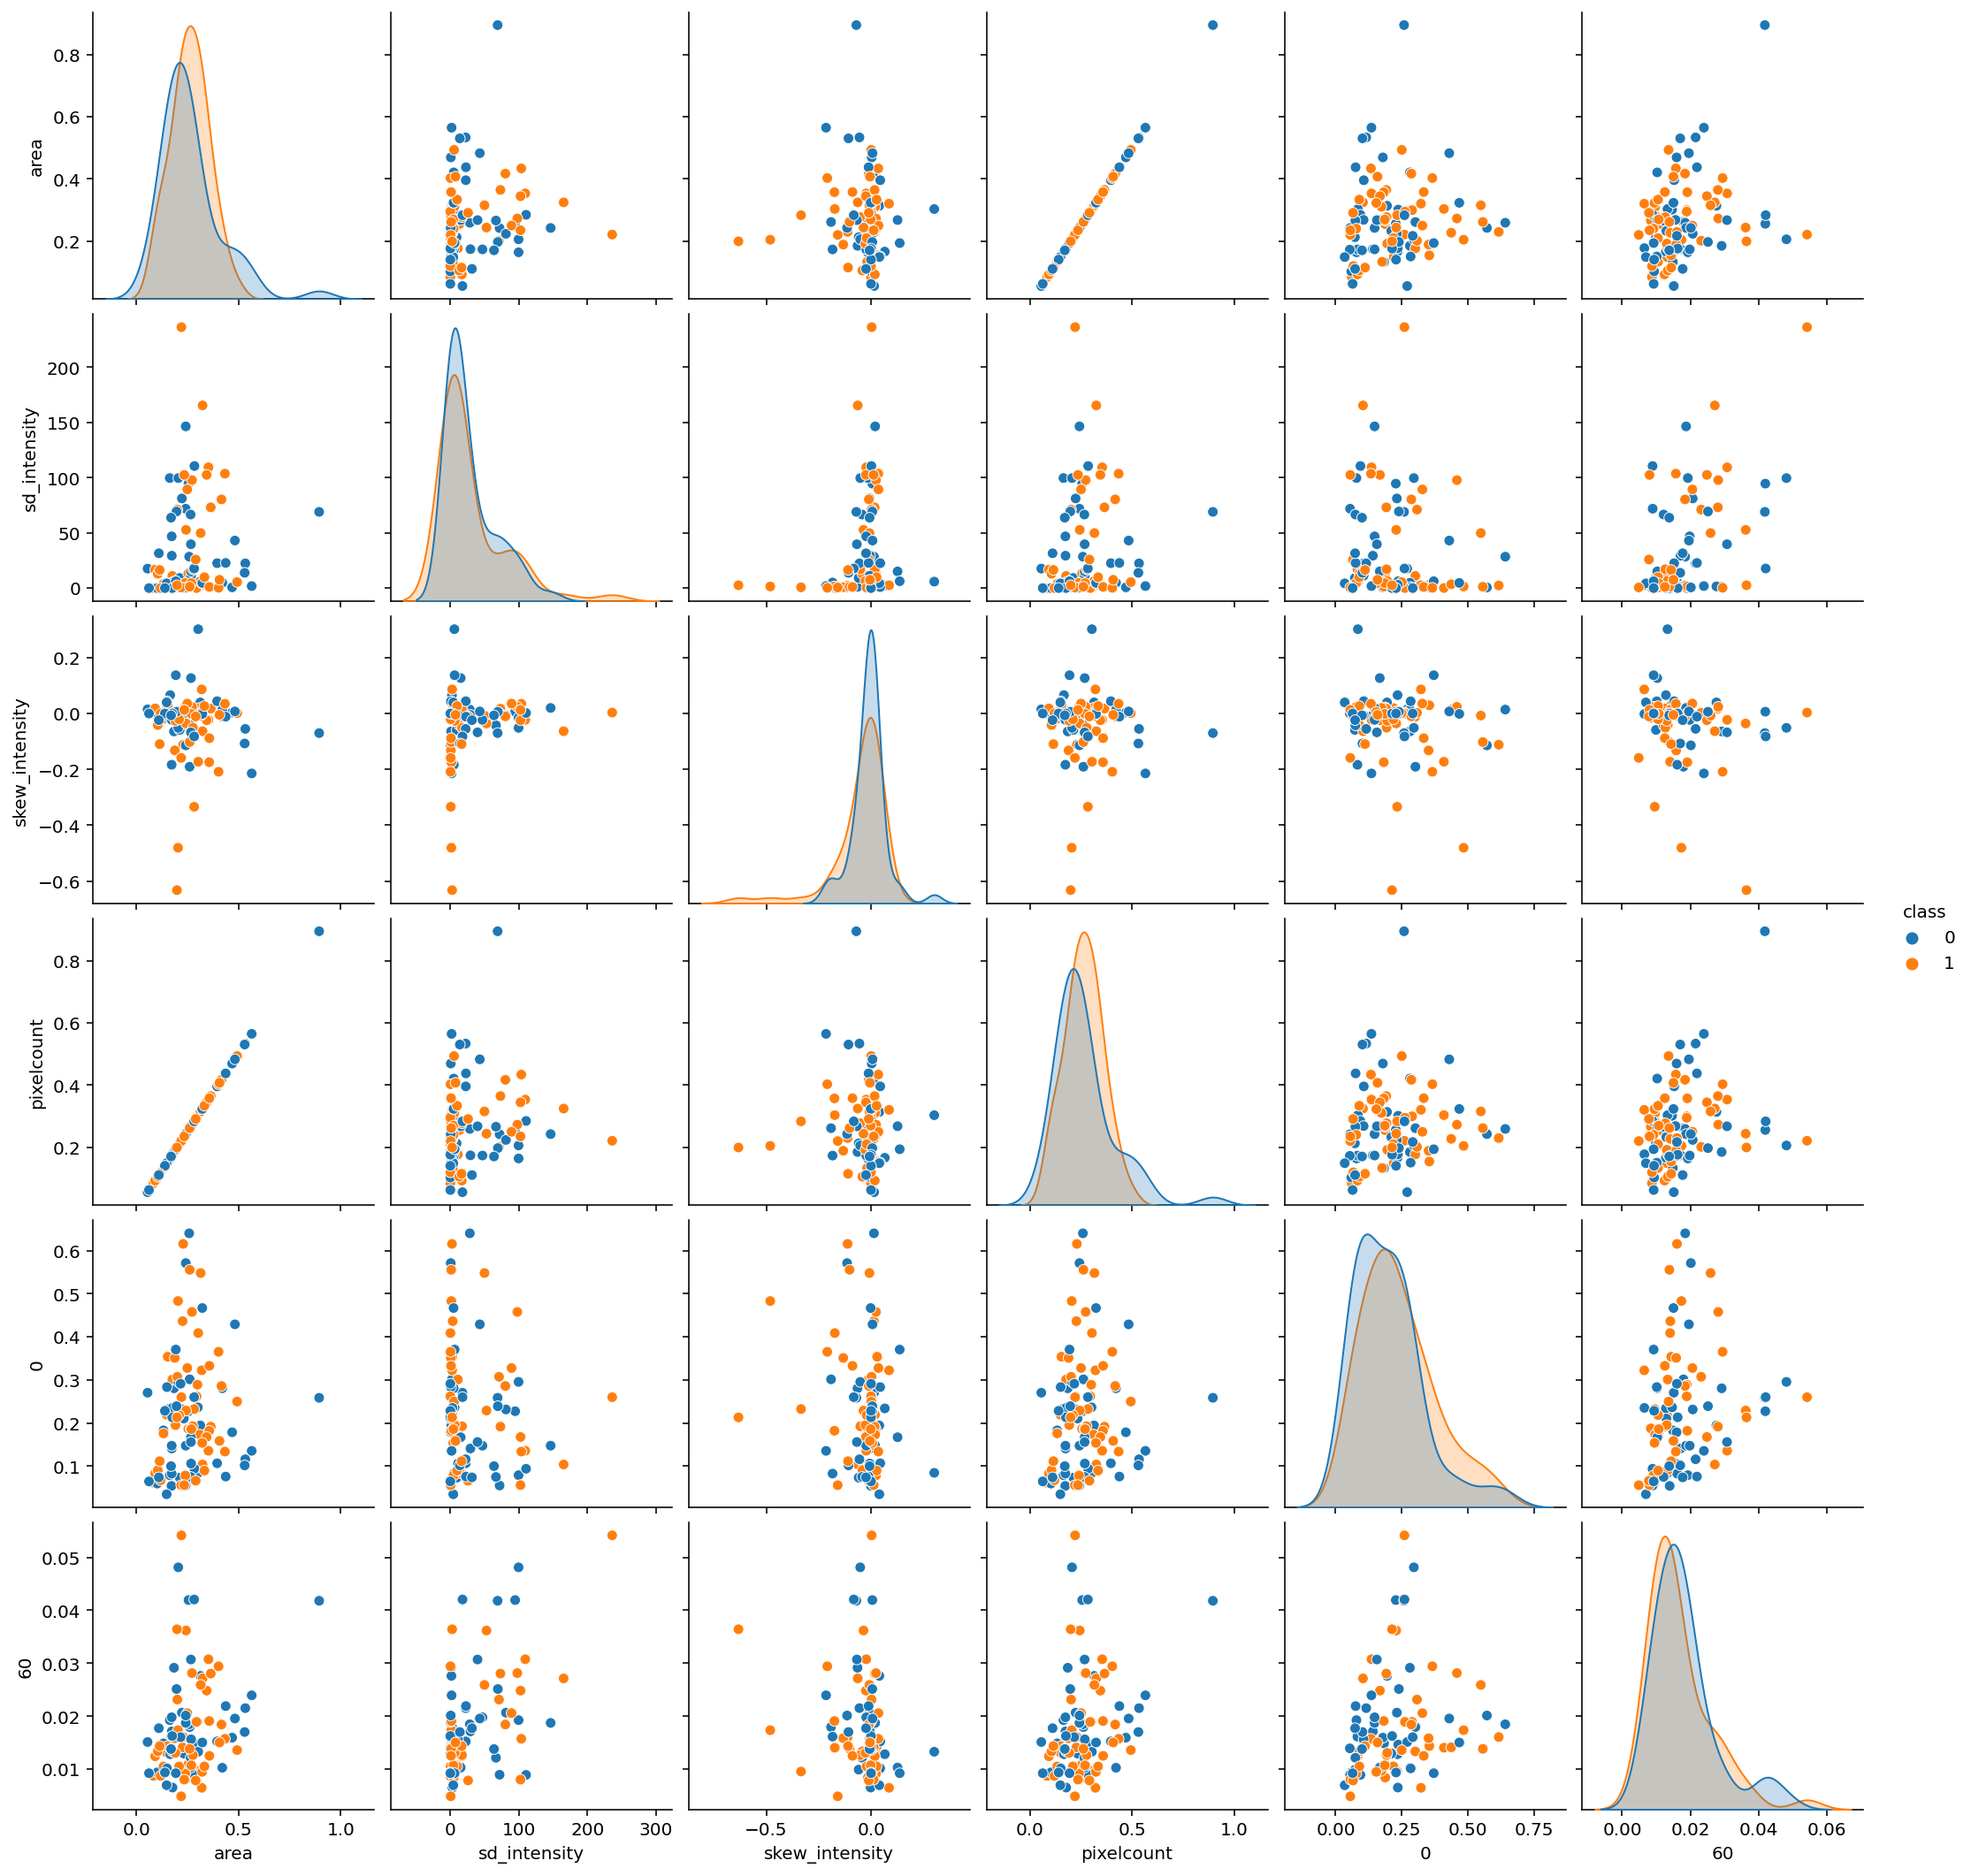

In [150]:
sns.pairplot(table_mix_train_temp,hue = 'class',diag_kind='kde')

# Logistic regression 
Decay formula:\
<Br>
$ Signal(t) = a \times Signal(t0) \times e^{-b \times kernel}$\
<Br>
$b =  - \frac {ln \frac {Signal(t)}{Signal(t0)}}{Kernel}$
<Br>
Remove the minus sign for compatebility with logistic\
Add a parmetre and beta
$ \theta = logistic(a + \beta \frac {ln \frac {Signal(t)}{Signal(t0)}}{Kernel})$
---
Simulation:

In [177]:
df = table_mix_train_features
y_0 = pd.Categorical(df['class']).codes
x_tzero = df['0'].values
x_tkernel = df['60'].values
x_0 = x_tzero/x_tkernel
kernel = 1 #no need to use this var since it is same


In [199]:
a = 0.5
b = 0.5
p  = 1 / (1 + np.exp(1+ 1*(-1 * np.log(x_0))))
np.round(p,2)

array([0.86, 0.81, 0.88, 0.93, 0.86, 0.72, 0.86, 0.76, 0.65, 0.78, 0.76,
       0.7 , 0.82, 0.82, 0.85, 0.85, 0.73, 0.7 , 0.84, 0.76, 0.89, 0.65,
       0.9 , 0.69, 0.93, 0.71, 0.86, 0.64, 0.94, 0.7 , 0.67, 0.91, 0.8 ,
       0.69, 0.79, 0.74, 0.86, 0.89, 0.72, 0.78, 0.87, 0.6 , 0.73, 0.92,
       0.91, 0.72, 0.87, 0.91, 0.86, 0.8 , 0.65, 0.72, 0.9 , 0.71, 0.87,
       0.89, 0.69, 0.71, 0.87, 0.78, 0.89, 0.72, 0.76, 0.87, 0.62, 0.89,
       0.86, 0.75, 0.86, 0.56, 0.91, 0.72, 0.74, 0.69, 0.94, 0.58, 0.85,
       0.86, 0.85, 0.74, 0.85, 0.66, 0.6 , 0.79, 0.9 , 0.69, 0.93, 0.73,
       0.68, 0.83, 0.59, 0.69, 0.71, 0.83, 0.95, 0.92, 0.68, 0.86, 0.91,
       0.91])

In [182]:
with pm.Model() as model_logistic_basic:
    a = pm.Normal('a',0,10)
    b = pm.Normal('b',0,10)
    rate = -1 * pm.math.log(x_tkernel/x_tzero)
    mu = a + pm.math.dot(rate,b)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd',-a/b)
    yl = pm.Bernoulli('yl',theta,observed = y_0)
    trace = pm.sample(4000, tune=4000, target_accept=0.99,random_seed=RANDOM_SEED)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 68 seconds.
The number of effective samples is smaller than 25% for some parameters.


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

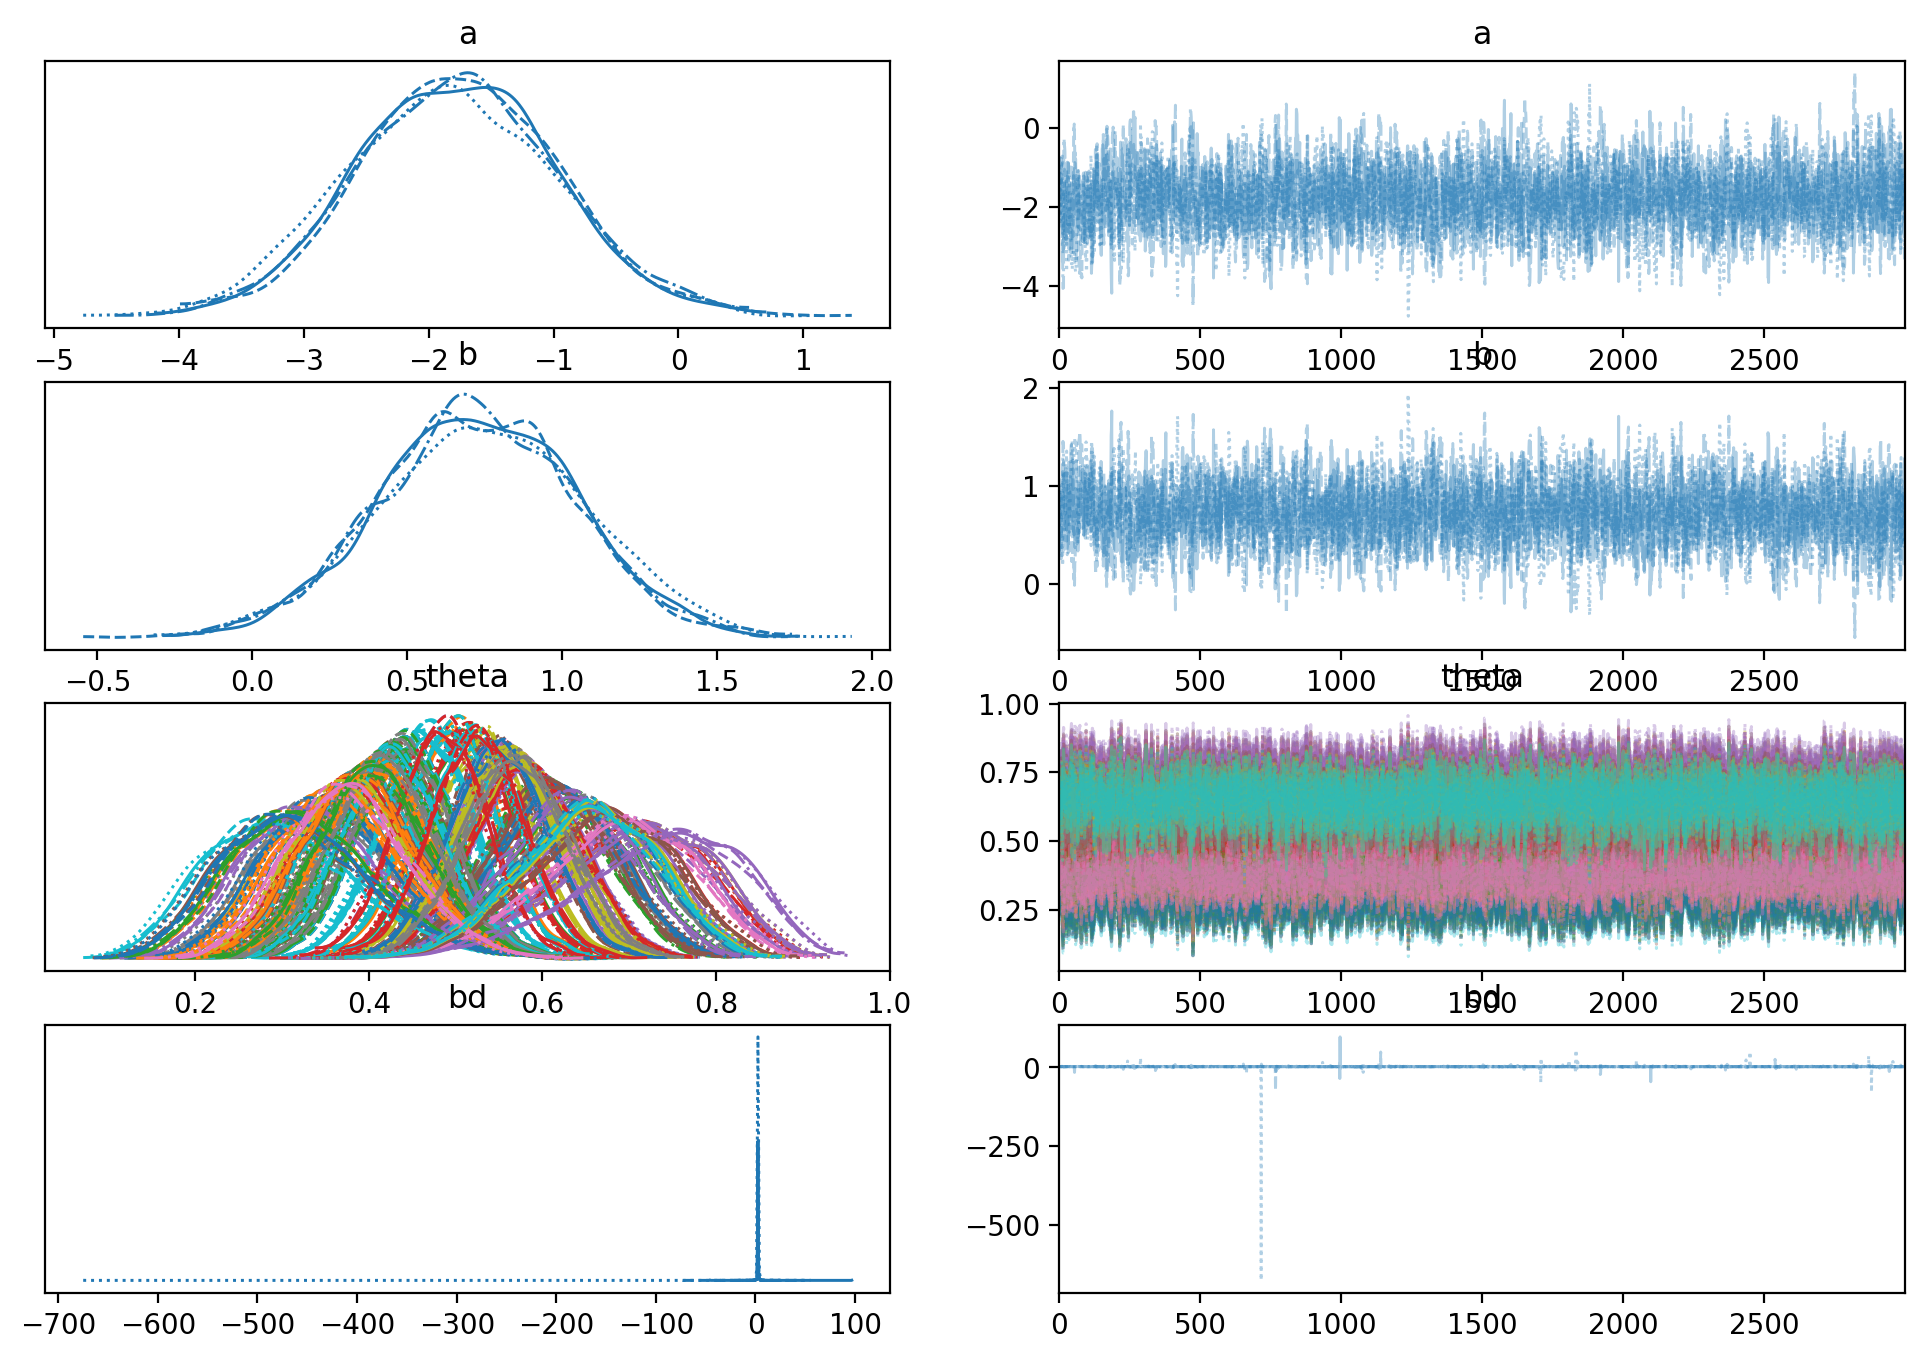

In [184]:
chain_1 = trace[1000:]
pm.traceplot(chain_1)

In [167]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.806,0.838,-3.304,-0.139,0.017,0.012,2423.0,2526.0,1.01
b,-0.741,0.333,-1.376,-0.110,0.007,0.005,2371.0,2486.0,1.01
theta[0],0.562,0.058,0.453,0.669,0.001,0.000,7568.0,7374.0,1.00
theta[1],0.499,0.052,0.397,0.592,0.000,0.000,11540.0,8476.0,1.00
theta[2],0.606,0.067,0.482,0.734,0.001,0.001,4646.0,5719.0,1.00
...,...,...,...,...,...,...,...,...,...
theta[96],0.375,0.072,0.245,0.516,0.001,0.001,3370.0,4951.0,1.00
theta[97],0.573,0.060,0.460,0.684,0.001,0.001,6523.0,6905.0,1.00
theta[98],0.657,0.080,0.505,0.805,0.001,0.001,3468.0,4334.0,1.00
theta[99],0.654,0.079,0.504,0.801,0.001,0.001,3511.0,4358.0,1.00


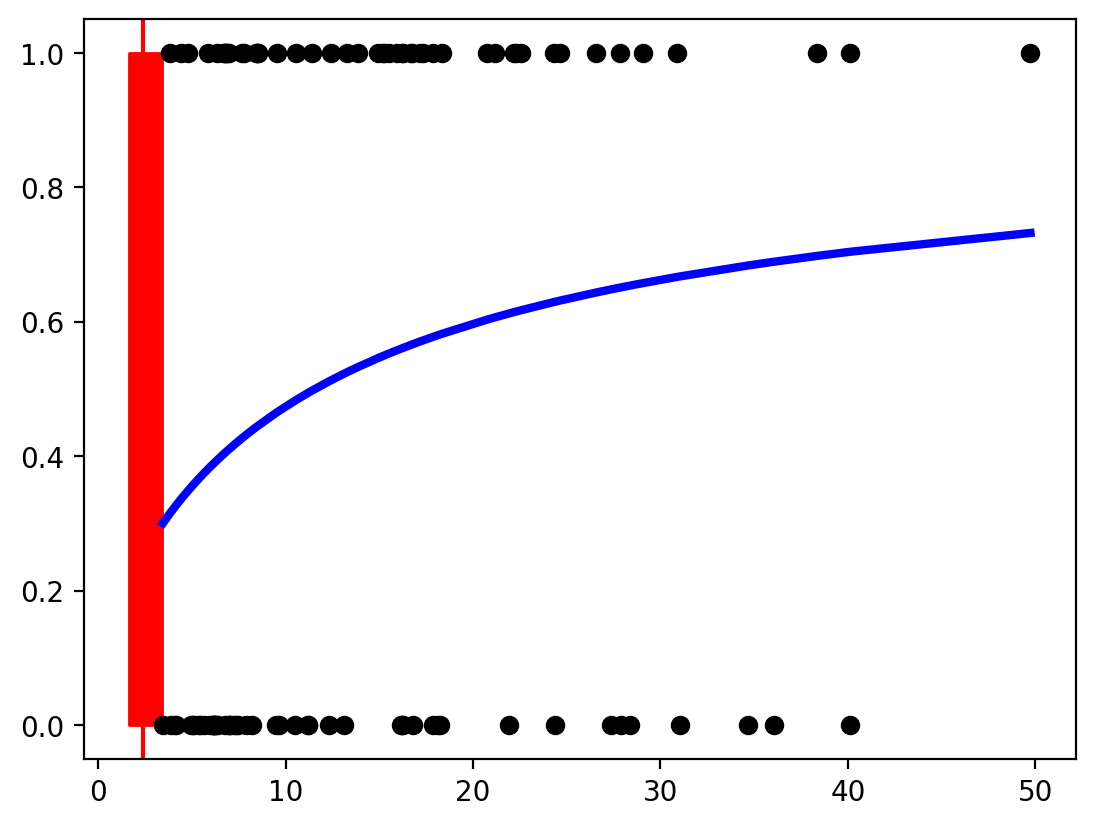

In [183]:
theta = trace['theta'].mean(0)
idx = np.argsort(x_0)
plt.plot(x_0[idx],theta[idx],color ='b',lw=3)
plt.axvline(trace['bd'].mean(),ymax=1,color = 'r')
bd_hdi = pm.hdi(trace['bd'])
plt.fill_betweenx([0,1],bd_hdi[0],bd_hdi[1], color = 'r')
plt.plot(x_0,y_0,'o',color = 'k')
